In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.constants import R
from matplotlib import gridspec

In [2]:
raw = pd.read_csv('../data/lab4_PHYS258.csv')
raw.head()

,Set,Set.1,Set.2,Set.3,Set.4,Set.5,Set.6,Run #1,Run #1.1,Run #1.2,Run #1.3
0,Absolute Pressure (cmHg),Ideal LogP (cmHg),Ideal Temperature (K),Left (cm),Right (cm),Δh (cm),Ln(P) (cmHg),Time (s),Voltage (V),Temperature (K),1/T (K^-1)
1,4.71,0.458,273,78.65,7.90,70.75,1.55,877.450,0.311,310.93,0.00
2,11.66,76.000,373,75.40,11.60,63.80,2.46,2263.850,0.329,328.78,0.00
3,18.86,NaN,NaN,72.00,15.40,56.60,2.94,2956.450,0.339,339.46,0.00
4,36.01,NaN,NaN,64.20,24.75,39.45,3.58,4091.400,0.354,354.43,0.00


In [3]:
def to_float(array):
    return [float(val) for val in array]

In [4]:
raw = raw.iloc[1:]
lnp = raw["Set.6"].values
temps = raw["Run #1.2"].values
lnp, temps = np.array(to_float(lnp)), np.array(to_float(temps))
pressure = np.e**lnp
temps_inv = np.array([1/temp for temp in temps])

In [5]:
def plot_fit_residuals(xlabel, ylabel, x_val, y_vals, fit_funcs = None, labels = None, sharex = True, 
                       errors = None, title=None, figsize=(6,6)):
    ''' IMPORTANT !!! If one function only must still be [y_vals_array]
    y_vals = [function1, function 2]
    fit_funcs = [fitted f1, fitted f2]
    errors = [errors f1, f2]
    '''
    
    if fit_funcs != None:
        fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[4, 1]}, sharex=sharex, 
                                     figsize=figsize)        
        for i in range(len(y_vals)):
            if labels!=None:
                a0.errorbar(x_val, y_vals[i], yerr = errors[i], marker='.', linestyle='None', capsize=3, label=labels[i])
            else: 
                a0.errorbar(x_val, y_vals[i], yerr = errors[i], marker='.', linestyle='None', capsize=3)
            add_length = .03*np.abs(max(x_val) - min(x_val))
            fit_from = min(x_val) - add_length
            fit_to = max(x_val) + add_length
            fit_x = np.linspace(fit_from, fit_to)
            a0.plot(fit_x, fit_funcs[i](fit_x), '-')
#             a0.plot(x_val, fit_funcs[i](x_val), '-')
            residuals = y_vals[i] - fit_funcs[i](x_val)
            a1.errorbar(x_val, residuals ,yerr = errors[i] ,marker='.', linestyle='None', capsize=3)
        if title!=None:
            a0.set_title(title)

        plt.xlabel(xlabel)
        a0.set_ylabel(ylabel)
        a1.axhline(y=0)
        if labels!=None:
            a0.legend()
            
        fig.tight_layout()
    # fig.set_size_inches(w=5,h=6)

In [6]:
fit, cov = np.polyfit(temps_inv,lnp,1, cov=True)
fit_fn = np.poly1d(fit)

p_error = 0.4  # uncertainty on cmHg measure: 0.4 cm 
lnp_errors = 1/(pressure) * p_error 
residuals = lnp - fit_fn(temps_inv)
print(fit, np.sqrt(np.diag(cov)))

[-5141.31781914    18.08973955] [15.3739022   0.04391094]


In [7]:
# plot_fit_residuals(xlabel='$1/T$ [1/K]', ylabel='$LnP$ [cmHg]', x_val=temps_inv, y_vals=[lnp], 
#                    fit_funcs=[fit_fn], errors=[lnp_errors])

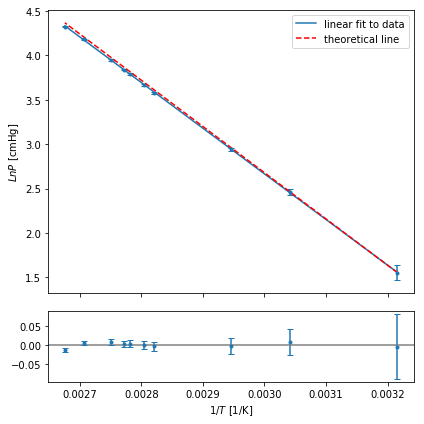

In [8]:
fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[4, 1]}, sharex=True, figsize=(6, 6))

a0.errorbar(temps_inv, lnp, yerr = lnp_errors, fmt='.', c='C0', linestyle='None', capsize=3)
a0.plot(temps_inv, fit_fn(temps_inv), '-', label='linear fit to data')
a0.plot(temps_inv, np.poly1d([-5207, 18.3])(temps_inv), 'r--', label='theoretical line')

plt.xlabel('$1/T$ [1/K]' )
a0.set_ylabel('$LnP$ [cmHg]')
a0.legend()

a1.axhline(y=0, color='gray')
a1.errorbar(temps_inv,residuals ,yerr = lnp_errors,fmt='.',linestyle='None', capsize=3)

fig.tight_layout()
fig.set_size_inches(w=6,h=6)
plt.savefig('linearfit.png', bbox_inches=None)

In [9]:
m_err = np.sqrt(sum([value**2 for value in residuals])/(len(residuals) - 2))
m_err = m_err / np.sqrt(sum([value**2 for value in temps_inv]))
print(m_err)
m_err += sum([value**2 for value in lnp_errors])
print(m_err)

0.7431307468288482
0.7524624963468981


In [10]:
def expo(x, a, b):
    return a * np.exp(- b/x) 

popt, pcov = curve_fit(expo, temps, pressure,)
print('P_0:', popt[0], '(-L/R):', popt[1])

def fit_exp(x):
    return expo(x, *popt)

P_0: 62550214.26338182 (-L/R): 5091.363238234325


In [11]:
# res = pressure - fit_exp(temps)
# fit_err = np.sqrt(sum([value**2 for value in res])) + np.sqrt(len(temps)*p_error)
# print(fit_err)

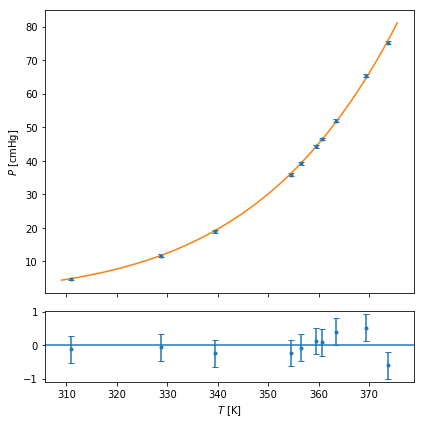

In [12]:
plot_fit_residuals(xlabel='$T$ [K]', ylabel='$P$ [cmHg]', x_val=temps, y_vals=[pressure], fit_funcs=[fit_exp], 
                   errors=[p_error])
plt.savefig('expofit.png', bbox_inches=None)

In [13]:
print(popt, np.sqrt(np.diag(pcov)))

[6.25502143e+07 5.09136324e+03] [6.52040633e+06 3.80299436e+01]
